<a href="https://colab.research.google.com/github/zahra-sharifzadeh/thesis_demo/blob/main/Ravdess/att_w2v/demo_att_w2v_mfc_coefficients_two_CNNAE_Parallel_Ravdess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Setup

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, glob
import librosa
import librosa.display
import torch.nn.functional as F

import IPython
from IPython.display import Audio

from IPython.display import Image
import warnings; warnings.filterwarnings('ignore') #matplot lib complains about librosa

In [2]:
try:
  from transformers import Wav2Vec2Model, Wav2Vec2Processor
except:
  !pip install transformers
  from transformers import Wav2Vec2Model, Wav2Vec2Processor


In [3]:
# needed to import dataset from google drive into colab
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [4]:
# copy RAVDESS dataset from gdrive and unzip
!cp '/content/gdrive/MyDrive/RAVDESS.zip' .
!unzip -q RAVDESS.zip

## Define features

Define features as in the previous notebook on this task from my ['sklearn-audio-classification' repo](https://github.com/IliaZenkov/sklearn-audio-classification). That notebook explains the motivation behind the Mel Spectrogram and its derivative MFCC, which we use as a feature. In short, we're looking for transitions in audible pitch frequencies.

**MFCCs alone provide the best accuracy in this model with training considerations in mind - and provide as good an accuracy as using chromagrams + mel spectrograms + MFCCs. We don't want extra complexity in a highly parameterized deep neural net such as this one** (unless we absolutely need it).



In [5]:
# RAVDESS native sample rate is 16000
sample_rate = 16000

# Mel Spectrograms are not directly used as a feature in this model
# Mel Spectrograms are used in calculating MFCCs, which are a higher-level representation of pitch transition
# MFCCs work better - left the mel spectrogram function here in case anyone wants to experiment
def feature_melspectrogram(
    waveform,
    sample_rate,
    fft = 1024,
    winlen = 512,
    window='hamming',
    hop=256,
    mels=128,
    ):

    # Produce the mel spectrogram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # Using 8khz as upper frequency bound should be enough for most speech classification tasks
    melspectrogram = librosa.feature.melspectrogram(
        y=waveform,
        sr=sample_rate,
        n_fft=fft,
        win_length=winlen,
        window=window,
        hop_length=hop,
        n_mels=mels,
        fmax=sample_rate/2)

    # convert from power (amplitude**2) to decibels
    # necessary for network to learn - doesn't converge with raw power spectrograms
    melspectrogram = librosa.power_to_db(melspectrogram, ref=np.max)

    return melspectrogram

def feature_mfcc(
    waveform,
    sample_rate,
    n_mfcc = 40,
    fft = 1024,
    winlen = 512,
    window='hamming',
    #hop=256, # increases # of time steps; was not helpful
    mels=128
    ):

    # Compute the MFCCs for all STFT frames
    # 40 mel filterbanks (n_mfcc) = 40 coefficients
    mfc_coefficients=librosa.feature.mfcc(
        y=waveform,
        sr=sample_rate,
        n_mfcc=n_mfcc,
        n_fft=fft,
        win_length=winlen,
        window=window,
        #hop_length=hop,
        n_mels=mels,
        fmax=sample_rate/2
        )

    return mfc_coefficients

def get_features(waveforms, features, samplerate):

    # initialize counter to track progress
    file_count = 0

    # process each waveform individually to get its MFCCs
    for waveform in waveforms:
        mfccs = feature_mfcc(waveform, sample_rate)
        features.append(mfccs)
        file_count += 1
        # print progress
        print('\r'+f' Processed {file_count}/{len(waveforms)} waveforms',end='')

    # return all features from list of waveforms
    return features

def get_waveforms(file):

    # load an individual sample audio file
    # read the full 3 seconds of the file, cut off the first 0.5s of silence; native sample rate = 48k
    # don't need to store the sample rate that librosa.load returns
    waveform, _ = librosa.load(file, duration=3, offset=0.5, sr=sample_rate)

    # make sure waveform vectors are homogenous by defining explicitly
    waveform_homo = np.zeros((int(sample_rate*3,)))
    waveform_homo[:len(waveform)] = waveform

    # return a single file's waveform
    return waveform_homo

# RAVDESS dataset emotions
# shift emotions left to be 0 indexed for PyTorch
emotions_dict ={
    '0':'surprised',
    '1':'neutral',
    '2':'calm',
    '3':'happy',
    '4':'sad',
    '5':'angry',
    '6':'fearful',
    '7':'disgust'
}

# Additional attributes from RAVDESS to play with
emotion_attributes = {
    '01': 'normal',
    '02': 'strong'
}

## Load Data and Extract Features


We process each file in the dataset and extract its features.

We return the waveforms and the labels (from the file names of the RAVDESS audio samples). We return the raw waveforms because we're going to do some extra processing.


In [6]:
# path to data for glob
data_path = '/content/Actor_*/*.wav'

def load_data():
    # features and labels
    emotions = []
    # raw waveforms to augment later
    waveforms = []
    # extra labels
    intensities, genders = [],[]
    # progress counter
    file_count = 0
    for file in glob.glob(data_path):
        # get file name with labels
        file_name = os.path.basename(file)

        # get emotion label from the sample's file
        emotion = int(file_name.split("-")[2])

        #  move surprise to 0 for cleaner behaviour with PyTorch/0-indexing
        if emotion == 8: emotion = 0 # surprise is now at 0 index; other emotion indeces unchanged

        # can convert emotion label to emotion string if desired, but
        # training on number is better; better convert to emotion string after predictions are ready
        # emotion = emotions_dict[str(emotion)]

        # get other labels we might want
        intensity = emotion_attributes[file_name.split("-")[3]]
        # even actors are female, odd are male
        if (int((file_name.split("-")[6]).split(".")[0]))%2==0:
            gender = 'female'
        else:
            gender = 'male'

        # get waveform from the sample
        waveform = get_waveforms(file)

        # store waveforms and labels
        waveforms.append(waveform)
        emotions.append(emotion)
        intensities.append(intensity) # store intensity in case we wish to predict
        genders.append(gender) # store gender in case we wish to predict

        file_count += 1
        # keep track of data loader's progress
        print('\r'+f' Processed {file_count}/{1440} audio samples',end='')

    return waveforms, emotions, intensities, genders

In [7]:
# load data
# init explicitly to prevent data leakage from past sessions, since load_data() appends
waveforms, emotions, intensities, genders = [],[],[],[]
waveforms, emotions, intensities, genders = load_data()

 Processed 1440/1440 audio samples

## Check extracted audio waveforms and labels:


In [8]:
print(f'Waveforms set: {len(waveforms)} samples')
# we have 1440 waveforms but we need to know their length too; should be 3 sec * 48k = 144k
print(f'Waveform signal length: {len(waveforms[0])}')
print(f'Emotions set: {len(emotions)} sample labels')

Waveforms set: 1440 samples
Waveform signal length: 48000
Emotions set: 1440 sample labels


Looks good. 1440 samples and 1440 labels in total.

**Waveforms are 144k long because 3 seconds * 48k sample rate = 144k length array representing the 3 second audio snippet.**

## Split into Train/Validation/Test Sets
We'll use an 80/10/10 train/validation/test split to maximize training data and keep a reasonable validation/test set.

**We're splitting waveforms so we can process train/validation/test waveforms separately and avoid data leakage.**

**Have to take care to split the sets proportionally w.r.t. emotion.**

**Yes, we can use sklearn - but to convince myself I've eradicated data leakage issues I did this manually.**

In [9]:
# from sklearn.model_selection import train_test_split
# waveforms = np.array(waveforms)
# # Your data and labels
# data = waveforms  # Replace with your data
# labels = np.array(emotions) # Replace with your labels

# # Split the data into training, testing, and validation sets
# test_size = 0.1  # You can adjust the ratio for the test set
# valid_size = 0.1  # You can adjust the ratio for the validation set

# # First, split into training and the remaining data
# remaining_data, X_test, remaining_labels, y_test = train_test_split(
#     data, labels, test_size=test_size, random_state=42)

# # Then, split the remaining data into validation and test sets
# X_train, X_valid, y_train, y_valid = train_test_split(
#     remaining_data, remaining_labels, test_size=valid_size, random_state=42)

# # Now, you have train_data, test_data, and valid_data, along with their corresponding labels.
# # Adjust the test_size and valid_size values as needed.
# # check shape of each set
# print(f'Training waveforms:{X_train.shape}, y_train:{y_train.shape}')
# print(f'Validation waveforms:{X_valid.shape}, y_valid:{y_valid.shape}')
# print(f'Test waveforms:{X_test.shape}, y_test:{y_test.shape}')

In [10]:
# create storage for train, validation, test sets and their indices
train_set,valid_set,test_set = [],[],[]
X_train,X_valid,X_test = [],[],[]
y_train,y_valid,y_test = [],[],[]

# convert waveforms to array for processing
waveforms = np.array(waveforms)

# process each emotion separately to make sure we builf balanced train/valid/test sets
for emotion_num in range(len(emotions_dict)):

    # find all indices of a single unique emotion
    emotion_indices = [index for index, emotion in enumerate(emotions) if emotion==emotion_num]

    # seed for reproducibility
    np.random.seed(69)
    # shuffle indicies
    # emotion_indices = np.random.permutation(emotion_indices)

    # store dim (length) of the emotion list to make indices
    dim = len(emotion_indices)

    # store indices of training, validation and test sets in 80/10/10 proportion
    # train set is first 80%
    train_indices = emotion_indices[:int(0.9*dim)]
    # validation set is next 10% (between 80% and 90%)
    valid_indices = emotion_indices[int(0.8*dim):int(0.9*dim)]
    # test set is last 10% (between 90% - end/100%)
    test_indices = emotion_indices[int(0.9*dim):]

    # create train waveforms/labels sets
    X_train.append(waveforms[train_indices,:])
    y_train.append(np.array([emotion_num]*len(train_indices),dtype=np.int32))
    # create validation waveforms/labels sets
    X_valid.append(waveforms[valid_indices,:])
    y_valid.append(np.array([emotion_num]*len(valid_indices),dtype=np.int32))
    # create test waveforms/labels sets
    X_test.append(waveforms[test_indices,:])
    y_test.append(np.array([emotion_num]*len(test_indices),dtype=np.int32))

    # store indices for each emotion set to verify uniqueness between sets
    train_set.append(train_indices)
    valid_set.append(valid_indices)
    test_set.append(test_indices)

# concatenate, in order, all waveforms back into one array
X_train = np.concatenate(X_train,axis=0)
X_valid = np.concatenate(X_valid,axis=0)
X_test = np.concatenate(X_test,axis=0)

# concatenate, in order, all emotions back into one array
y_train = np.concatenate(y_train,axis=0)
y_valid = np.concatenate(y_valid,axis=0)
y_test = np.concatenate(y_test,axis=0)

# combine and store indices for all emotions' train, validation, test sets to verify uniqueness of sets
train_set = np.concatenate(train_set,axis=0)
valid_set = np.concatenate(valid_set,axis=0)
test_set = np.concatenate(test_set,axis=0)

# check shape of each set
print(f'Training waveforms:{X_train.shape}, y_train:{y_train.shape}')
print(f'Validation waveforms:{X_valid.shape}, y_valid:{y_valid.shape}')
print(f'Test waveforms:{X_test.shape}, y_test:{y_test.shape}')


Training waveforms:(1290, 48000), y_train:(1290,)
Validation waveforms:(143, 48000), y_valid:(143,)
Test waveforms:(150, 48000), y_test:(150,)


## Extract Features


Extract the features from unaugmented waveforms first. In the next step, we'll append features from augmented waveforms to these 'native' features.

In [11]:
# # initialize feature arrays
# # We extract MFCC features from waveforms and store in respective 'features' array
# features_train, features_valid, features_test = [],[],[]

# print('Train waveforms:') # get training set features
# features_train = get_features(X_train, features_train, sample_rate)

# print('\n\nValidation waveforms:') # get validation set features
# features_valid = get_features(X_valid, features_valid, sample_rate)

# print('\n\nTest waveforms:') # get test set features
# features_test = get_features(X_test, features_test, sample_rate)

# print(f'\n\nFeatures set: {len(features_train)+len(features_test)+len(features_valid)} total, {len(features_train)} train, {len(features_valid)} validation, {len(features_test)} test samples')
# print(f'Features (MFC coefficient matrix) shape: {len(features_train[0])} mel frequency coefficients x {len(features_train[0][1])} time steps')

## Augmenting the Data with AWGN - Additive White Gaussian Noise

### Motivation

Since our dataset is small, it is prone to overfitting - especially with highly parameterized deep neural net models
such as the one we aim to build in this notebook. As such, we're going to want to augment our data. Generating more real samples will be immensely difficult. Instead, we can add white noise to the audio signals - not only to mask the effect of random noise present in the training set - but also **to create pseudo-new training samples and offset the impact of noise intrinsic to the dataset.**

In addition, the RAVDESS dataset is extremely clean - we will likely want to make predictions on noisy, real-world data - yet another reason to augment the training data.

We're going to use Additive White Gaussian Noise (AWGN). It's Additive because we're adding it to the source audio signal,
**it's Gaussian because the noise vector will be sampled from a normal distribution and have a time average of zero (zero-mean), and it's white because after a whitening transformation the noise will add power to the audio signal uniformly across the frequency distribution.**

We need a good balance of noise - too little will be useless, and too much will make it too difficult for the network to learn from the training data. **Note that this is just for training - we would _not_ need to add AWGN to real-world data on which we make predictions** (although we could).

### Math
The key parameters in AWGN are the signal to noise ratio (SNR), defining the magnitude of the noise added w.r.t. the audio signal. We parameterize AWGN with the minimum and maximize SNR so we can pick a random SNR to use in augmenting each sample's waveform.

We need to constrain covariance to make it true AWGN. **We make a zero-mean vector of Gaussian noises (np.random.normal) that are statistically dependent. We need to apply a [whitening transformation](https://en.wikipedia.org/wiki/Whitening_transformation)**, a linear transformation taking a vector of random normal (Gaussian) variables with a known covariance matrix and mapping it to a new vector whose covariance is the identity matrix, i.e. the vector is now perfectly uncorrelated with a diaganol covariance matrix, each point of noise having variance == stdev == 1. **The whitening transformation by definition transforms a vector into a white noise vector.**

We're going to add the AWGN augmented waveforms as new samples to our dataset. **Since we generate AWGN which is random for each and every sample - random random noise - we can add multiples of our noise-augmented dataset. I'll add 2 extra identical, randomly noisy datasets with 1440 samples each to get a dataset with 1440 native + 1440x2 == 4320 noisy samples.**

In [12]:
# def awgn_augmentation(waveform, multiples=2, bits=16, snr_min=15, snr_max=30):

#     # get length of waveform (should be 3*48k = 144k)
#     wave_len = len(waveform)

#     # Generate normally distributed (Gaussian) noises
#     # one for each waveform and multiple (i.e. wave_len*multiples noises)
#     noise = np.random.normal(size=(multiples, wave_len))

#     # Normalize waveform and noise
#     norm_constant = 2.0**(bits-1)
#     norm_wave = waveform / norm_constant
#     norm_noise = noise / norm_constant

#     # Compute power of waveform and power of noise
#     signal_power = np.sum(norm_wave ** 2) / wave_len
#     noise_power = np.sum(norm_noise ** 2, axis=1) / wave_len

#     # Choose random SNR in decibels in range [15,30]
#     snr = np.random.randint(snr_min, snr_max)

#     # Apply whitening transformation: make the Gaussian noise into Gaussian white noise
#     # Compute the covariance matrix used to whiten each noise
#     # actual SNR = signal/noise (power)
#     # actual noise power = 10**(-snr/10)
#     covariance = np.sqrt((signal_power / noise_power) * 10 ** (- snr / 10))
#     # Get covariance matrix with dim: (144000, 2) so we can transform 2 noises: dim (2, 144000)
#     covariance = np.ones((wave_len, multiples)) * covariance

#     # Since covariance and noise are arrays, * is the haddamard product
#     # Take Haddamard product of covariance and noise to generate white noise
#     multiple_augmented_waveforms = waveform + covariance.T * noise

#     return multiple_augmented_waveforms

In [13]:
# def augment_waveforms(waveforms,  emotions, multiples):
#     # keep track of how many waveforms we've processed so we can add correct emotion label in the same order
#     emotion_count = 0
#     # keep track of how many augmented samples we've added
#     added_count = 0
#     # convert emotion array to list for more efficient appending
#     emotions = emotions.tolist()

#     for waveform in waveforms:

#         # Generate 2 augmented multiples of the dataset, i.e. 1440 native + 1440*2 noisy = 4320 samples total
#         augmented_waveforms = awgn_augmentation(waveform, multiples=multiples)
#         waveforms= np.concatenate([waveforms,augmented_waveforms],axis=0)


#         # compute spectrogram for each of 2 augmented waveforms
#         for augmented_waveform in augmented_waveforms:

#             # Compute MFCCs over augmented waveforms
#             augmented_mfcc = feature_mfcc(augmented_waveform, sample_rate=sample_rate)

#             # append the augmented spectrogram to the rest of the native data
#             # features.append(augmented_mfcc)
#             # print(augmented_waveforms.shape)
#             emotions.append(emotions[emotion_count])

#             # keep track of new augmented samples
#             added_count += 1

#             # check progress
#             print('\r'+f'Processed {emotion_count + 1}/{len(waveforms)} waveforms for {added_count}/{len(waveforms)*multiples} new augmented samples',end='')

#         # keep track of the emotion labels to append in order
#         emotion_count += 1

#         # store augmented waveforms to check their shape
#         augmented_waveforms_temp.append(augmented_waveforms)


#     return waveforms, augmented_mfcc,  emotions

### Compute AWGN-augmented features and add to the rest of the dataset



In [14]:
def addAWGN(signal, num_bits=16, augmented_num=2, snr_low=15, snr_high=30):
    signal_len = len(signal)
    # Generate White Gaussian noise
    noise = np.random.normal(size=(augmented_num, signal_len))
    # Normalize signal and noise
    norm_constant = 2.0**(num_bits-1)
    signal_norm = signal / norm_constant
    noise_norm = noise / norm_constant
    # Compute signal and noise power
    s_power = np.sum(signal_norm ** 2) / signal_len
    n_power = np.sum(noise_norm ** 2, axis=1) / signal_len
    # Random SNR: Uniform [15, 30] in dB
    target_snr = np.random.randint(snr_low, snr_high)
    # Compute K (covariance matrix) for each noise
    K = np.sqrt((s_power / n_power) * 10 ** (- target_snr / 10))
    K = np.ones((signal_len, augmented_num)) * K
    # Generate noisy signal
    return signal + K.T * noise

In [15]:
aug_signals = []
aug_labels = []
emotion_list = y_train.tolist()
for i in range(X_train.shape[0]):
    signal = X_train[i,:]
    augmented_signals = addAWGN(signal)
    for j in range(augmented_signals.shape[0]):
        aug_labels.append(emotion_list[i])
        aug_signals.append(augmented_signals[j,:])
        # data = data.append(data.iloc[i], ignore_index=True)
    print("\r Processed {}/{} files".format(i+1,X_train.shape[0]),end='')
aug_signals = np.stack(aug_signals,axis=0)
X_train = np.concatenate([X_train,aug_signals],axis=0)
aug_labels = np.stack(aug_labels,axis=0)
y_train = np.concatenate([y_train,aug_labels])
print('')
print(f'X_train:{X_train.shape}, Y_train:{y_train.shape}')

 Processed 1290/1290 files
X_train:(3870, 48000), Y_train:(3870,)


In [16]:
aug_signals = []
aug_labels = []
emotion_list = y_valid.tolist()
for i in range(X_valid.shape[0]):
    signal = X_valid[i,:]
    augmented_signals = addAWGN(signal)
    for j in range(augmented_signals.shape[0]):
        aug_labels.append(emotion_list[i])
        aug_signals.append(augmented_signals[j,:])
        # data = data.append(data.iloc[i], ignore_index=True)
    print("\r Processed {}/{} files".format(i+1,y_valid.shape[0]),end='')
aug_signals = np.stack(aug_signals,axis=0)
X_valid = np.concatenate([X_valid,aug_signals],axis=0)
aug_labels = np.stack(aug_labels,axis=0)
y_valid = np.concatenate([y_valid,aug_labels])
print('')
print(f'X_valid:{X_valid.shape}, y_valid:{y_valid.shape}')

 Processed 143/143 files
X_valid:(429, 48000), y_valid:(429,)


In [17]:
aug_signals = []
aug_labels = []
emotion_list = y_test.tolist()
for i in range(X_test.shape[0]):
    signal = X_test[i,:]
    augmented_signals = addAWGN(signal)
    for j in range(augmented_signals.shape[0]):
        aug_labels.append(emotion_list[i])
        aug_signals.append(augmented_signals[j,:])
        # data = data.append(data.iloc[i], ignore_index=True)
    print("\r Processed {}/{} files".format(i+1,y_test.shape[0]),end='')
aug_signals = np.stack(aug_signals,axis=0)
X_test = np.concatenate([X_test,aug_signals],axis=0)
aug_labels = np.stack(aug_labels,axis=0)
y_test = np.concatenate([y_test,aug_labels])
print('')
print(f'X_test:{X_test.shape}, Y_test:{y_test.shape}')

 Processed 150/150 files
X_test:(450, 48000), Y_test:(450,)


In [18]:
# initialize feature arrays
# We extract MFCC features from waveforms and store in respective 'features' array
features_train, features_valid, features_test = [],[],[]

print('Train waveforms:') # get training set features
features_train = get_features(X_train, features_train, sample_rate)

print('\n\nValidation waveforms:') # get validation set features
features_valid = get_features(X_valid, features_valid, sample_rate)

print('\n\nTest waveforms:') # get test set features
features_test = get_features(X_test, features_test, sample_rate)

print(f'\n\nFeatures set: {len(features_train)+len(features_test)} total, {len(features_train)} train, {len(features_test)} test samples')
print(f'Features (MFC coefficient matrix) shape: {len(features_train[0])} mel frequency coefficients x {len(features_train[0][1])} time steps')

Train waveforms:
 Processed 3870/3870 waveforms

Validation waveforms:
 Processed 429/429 waveforms

Test waveforms:
 Processed 450/450 waveforms

Features set: 4320 total, 3870 train, 450 test samples
Features (MFC coefficient matrix) shape: 40 mel frequency coefficients x 94 time steps


In [19]:
# # # store augmented waveforms to verify their shape and random-ness
# augmented_waveforms_temp = []

# # # specify multiples of our dataset to add as augmented data
# multiples = 2

# # print('Train waveforms:') # augment waveforms of training set
# # signal, augmented_mfcc,  emotions
# signal, features_train , y_train = augment_waveforms(X_train,  y_train, multiples)

# # print('\n\nValidation waveforms:') # augment waveforms of validation set
# # features_valid, y_valid = augment_waveforms(X_valid,  y_valid, multiples)

# # print('\n\nTest waveforms:') # augment waveforms of test set
# # features_test, y_test = augment_waveforms(X_test,  y_test, multiples)

# # # Check new shape of extracted features and data:
# # print(f'\n\nNative + Augmented Features set: {len(features_train)+len(features_test)+len(features_valid)} total, {len(features_train)} train, {len(features_valid)} validation, {len(features_test)} test samples')
# # print(f'{len(y_train)} training sample labels, {len(y_valid)} validation sample labels, {len(y_test)} test sample labels')


### Check Augmented Waveforms:

In [20]:
# # pick a random waveform, but same one from native and augmented set for easier comparison
# plt.figure(figsize=(15,4))
# plt.subplot(1, 2, 1)
# librosa.display.waveshow(waveforms[12], sr=sample_rate)
# plt.title('Native')

# plt.subplot(1, 2, 2)
# # augmented waveforms are 2D len 1440 list with 2 waveforms in each position
# librosa.display.waveshow(augmented_waveforms_temp[0][0], sr=sample_rate)
# plt.title('AWGN Augmented')
# plt.show()

# plt.figure(figsize=(15,4))
# plt.subplot(1, 2, 1)
# librosa.display.waveshow(augmented_waveforms_temp[2][0], sr=sample_rate)
# plt.title('AWGN Augmented')

# plt.subplot(1, 2, 2)
# librosa.display.waveshow(augmented_waveforms_temp[7][0], sr=sample_rate)
# plt.title('AWGN Augmented')
# plt.show()


Looks noisy alright. Noise is clearly visible in otherwise-silent regions of the waveform. We can see the variability of the noise, which should have an SNR between 15 and 30.

**Note that augmentation was only done after splitting data into train, validation, and test sets - and we processed each set separately.**

**When we augmented the data before splitting it, test and validation data leaked into the training set giving a 97% test accuracy after training.**

## Format Data into Tensor Ready 4D Arrays
We don't have a colour channel in our MFCC feature array of dim (#samples, #MFC coefficients, time steps). **We have an analog of a black and white image: instead of 3 colour channels, we have 1 signal intensity channel: magnitude of each of 40 mel frequency coefficients at time t.**

**We need an input channel dim to expand to output channels using CNN filters. We create a dummy channel dim to expand features into 2D-CNN-ready 4D tensor format: N x C x H x W.**

In [21]:
# need to make dummy input channel for CNN input feature tensor
features_train = np.expand_dims(features_train,1)
features_valid = np.expand_dims(features_valid, 1)
features_test = np.expand_dims(features_test,1)

# # convert emotion labels from list back to numpy arrays for PyTorch to work with
y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_test = np.array(y_test)

# confiorm that we have tensor-ready 4D data array
# should print (batch, channel, width, height) == (4320, 1, 128, 282) when multiples==2
print(f'Shape of 4D feature array for input tensor: {features_train.shape} train, {features_test.shape} test')
print(f'Shape of emotion labels: {y_train.shape} train, {y_test.shape} test')

Shape of 4D feature array for input tensor: (3870, 1, 40, 94) train, (450, 1, 40, 94) test
Shape of emotion labels: (3870,) train, (450,) test


In [22]:
X_train.shape

(3870, 48000)

In [23]:
# free up some RAM - no longer need full feature set or any waveforms
# del features_train, features_valid, features_test, waveforms, augmented_waveforms_temp

## Feature Scaling
Scaling will drastically decrease the length of time the model needs to train to convergence - it will have easier computations to perform on smaller magnitudes. **For reference, scaling reduces the time to convergence from about 500 to 200 epochs for this model.**

**Standard Scaling makes the most sense because we have features whose target distribution we don't know.** When I performed classification on this dataset with an MLP classifier standard scaling was best across a variety of conditions and features.


In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


#### Scale the training data ####
# store shape so we can transform it back
N,C,H,W = features_train.shape
# Reshape to 1D because StandardScaler operates on a 1D array
# tell numpy to infer shape of 1D array with '-1' argument
features_train = np.reshape(features_train, (N,-1))
features_train = scaler.fit_transform(features_train)
# Transform back to NxCxHxW 4D tensor format
features_train = np.reshape(features_train, (N,C,H,W))

# ##### Scale the validation set ####
N,C,H,W = features_valid.shape
features_valid = np.reshape(features_valid, (N,-1))
features_valid = scaler.transform(features_valid)
features_valid = np.reshape(features_valid, (N,C,H,W))

#### Scale the test set ####
N,C,H,W = features_test.shape
features_test = np.reshape(features_test, (N,-1))
features_test = scaler.transform(features_test)
features_test = np.reshape(features_test, (N,C,H,W))

# check shape of each set again
print(f'X_train scaled:{features_train.shape}, y_train:{y_train.shape}')
print(f'X_valid scaled:{features_valid.shape}, y_valid:{y_valid.shape}')
print(f'X_test scaled:{features_test.shape}, y_test:{y_test.shape}')

X_train scaled:(3870, 1, 40, 94), y_train:(3870,)
X_valid scaled:(429, 1, 40, 94), y_valid:(429,)
X_test scaled:(450, 1, 40, 94), y_test:(450,)


## Save and Reload Data as NumPy Arrays
We can save the training/validation/test data as numpy arrays to enable faster loading in case the notebook kernel crashes / google colab runtime crashes / any number of reasons the training data might be cleared from memory. This is much faster than loading 1440 files and computing their features again - not to mention augmented features.

In [25]:
###### SAVE #########
# choose save file name
filename = '/content/gdrive/MyDrive/att_w2v_kfold/featurs+rawAudios+labls.npy'

# open file in write mode and write data
with open(filename, 'wb') as f:
    np.save(f, features_train)
    np.save(f, X_train)
    np.save(f, features_test)
    np.save(f, X_test)

    np.save(f, y_train)
    np.save(f, y_test)

print(f'Features and labels saved to {filename}')

Features and labels saved to /content/gdrive/MyDrive/att_w2v_kfold/featurs+rawAudios+labls.npy


In [26]:
##### LOAD #########
# choose load file name
filename = '/content/gdrive/MyDrive/att_w2v_kfold/features+rawAudio+labels.npy'

# open file in read mode and read data
with open(filename, 'rb') as f:
    features_train = np.load(f)
    X_train = np.load(f)

    features_valid = np.load(f)
    X_valid = np.load(f)


    features_test = np.load(f)
    X_test = np.load(f)

    y_train = np.load(f)
    y_valid = np.load(f)
    y_test = np.load(f)

# Check that we've recovered the right data
print(f'X_train:{X_train.shape}, features_train:{features_train.shape}, y_train:{y_train.shape}')
print(f'X_valid:{features_valid.shape},features_valid: {features_valid.shape}, y_valid:{y_valid.shape}')
print(f'X_test:{X_test.shape} features_test: {features_test.shape}, y_test:{y_test.shape}')

X_train:(3483, 48000), features_train:(3483, 1, 40, 94), y_train:(3483,)
X_valid:(387, 1, 40, 94),features_valid: (387, 1, 40, 94), y_valid:(387,)
X_test:(450, 48000) features_test: (450, 1, 40, 94), y_test:(450,)


In [27]:
X_train.shape

(3483, 48000)

In [28]:
# class SpatialAttention(nn.Module):
#     def __init__(self, in_channels):
#         super(SpatialAttention, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels * 2, 1, kernel_size=1)  # Double the channels in the convolution
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         # Assuming x has shape [batches, 64, 1, 8]
#         avg_pool = F.avg_pool2d(x, kernel_size=(1, x.size(3)))
#         max_pool = F.max_pool2d(x, kernel_size=(1, x.size(3)))

#         # Double the channels in the features concatenation
#         features = torch.cat([avg_pool, max_pool], dim=1)

#         attention = self.conv1(features)
#         attention = self.sigmoid(attention)

#         # Applying attention to the input tensor along the spatial dimension
#         x = x * attention

#         return x

# # Example usage
# batches, channels, height, width = 2, 64, 1, 2
# input_tensor = torch.randn(batches, channels, height, width)
# attention_module = SpatialAttention(in_channels=channels)
# output_tensor = attention_module(input_tensor)

# print("Input shape:", input_tensor.shape)
# print("Output shape:", output_tensor.shape)


In [29]:
# class ChannelAttention(nn.Module):
#     def __init__(self, in_channels, reduction=16):
#         super(ChannelAttention, self).__init__()
#         self.avg_pool = nn.AdaptiveAvgPool2d(1)
#         self.max_pool = nn.AdaptiveMaxPool2d(1)
#         self.fc = nn.Sequential(
#             nn.Linear(in_channels, in_channels // reduction),
#             nn.ReLU(),
#             nn.Linear(in_channels // reduction, in_channels),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         avg_pool = self.avg_pool(x).view(x.size(0), -1)
#         max_pool = self.max_pool(x).view(x.size(0), -1)
#         channel_att = self.fc(avg_pool + max_pool).view(x.size(0), x.size(1), 1, 1)
#         x = x * channel_att
#         return x


# # Example usage
# batches, channels, height, width = 2, 64, 1, 2
# input_tensor = torch.randn(batches, channels, height, width)
# attention_module = ChannelAttention(in_channels=channels)
# output_tensor = attention_module(input_tensor)

# print("Input shape:", input_tensor.shape)
# print("Output shape:", output_tensor.shape)



In [30]:
import torch
import torch.nn as nn

class Encoder1(nn.Module):
    def __init__(self):
        super(Encoder1, self).__init__()

        self.encoder1 = nn.Sequential(
            # 1st 2D convolution layer
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.SELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.3),

            # 2nd 2D convolution layer
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.SELU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),

            # 3rd 2D convolution layer
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.SELU(),
            nn.MaxPool2d(kernel_size=4, stride=4)
        )

    def forward(self, x):
        return self.encoder1(x)





In [31]:
class Decoder1(nn.Module):
    def __init__(self):
        super(Decoder1, self).__init__()

        self.decoder1 = nn.Sequential(
            # 1st 2D transpose convolution layer
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=(1, 4), padding=0, output_padding=(0, 2)),
            nn.BatchNorm2d(32),
            nn.SELU(),

            # 2nd 2D transpose convolution layer
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=4, padding=0, output_padding=(1, 2)),
            nn.BatchNorm2d(16),
            nn.SELU(),

            # 3rd 2D transpose convolution layer
            nn.ConvTranspose2d(16, 1, kernel_size=(3,7), stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        return self.decoder1(x)


In [32]:

class Autoencoder1(nn.Module):
    def __init__(self):
        super(Autoencoder1, self).__init__()
        self.encoder = Encoder1()
        # self.spatial_attention = SpatialAttention(64)
        # self.channel_attention = ChannelAttention(64)
        self.decoder = Decoder1()

    def forward(self, x):
        encoded = self.encoder(x)
        # print("encoded1:", encoded.shape)
        # sa = self.spatial_attention(encoded)
        # print("sa1:",sa.shape)
        # ca = self.channel_attention(encoded)
        # print("ca1:", ca.shape)
        # att_encoded = sa + ca + encoded

        decoded = self.decoder(encoded)
        return encoded, decoded


In [33]:
# Example usage
autoencoder = Autoencoder1()
input_data = torch.randn(1, 1, 40, 94)  # Replace with your input shape
encoded1, decoded1 = autoencoder(input_data)
encoded1.shape, decoded1.shape

(torch.Size([1, 64, 1, 2]), torch.Size([1, 1, 40, 94]))

In [34]:
import torch.nn as nn

class Encoder2(nn.Module):
    def __init__(self):
        super(Encoder2, self).__init__()

        # Define the 2D convolutional layers
        self.conv2Dblock = nn.Sequential(
            # 1st 2D convolution layer
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.SELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.3),

            # 2nd 2D convolution layer
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.SELU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),

            # 3rd 2D convolution layer
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.SELU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3)
        )

    def forward(self, x):
        # Pass the input through the convolutional layers
        return self.conv2Dblock(x)



In [35]:
import torch.nn as nn

class Decoder2(nn.Module):
    def __init__(self):
        super(Decoder2, self).__init__()

        # Define the 2D transposed convolutional layers for the decoder
        self.decoder2 = nn.Sequential(
            # 1st 2D transposed convolution layer
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=(1, 4), padding=0, output_padding=(0, 2)),
            nn.BatchNorm2d(32),
            nn.SELU(),

            # 2nd 2D transposed convolution layer
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=4, padding=0, output_padding=(1, 2)),
            nn.BatchNorm2d(16),
            nn.SELU(),

            # 3rd 2D transposed convolution layer
            nn.ConvTranspose2d(16, 1, kernel_size=(3,7), stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        # Pass the input through the decoder's transposed convolutional layers
        return self.decoder2(x)



In [36]:
import torch.nn as nn

class Autoencoder2(nn.Module):
    def __init__(self):
        super(Autoencoder2, self).__init__()

        # Define the encoder and decoder
        self.encoder = Encoder2()
        # self.spatial_attention = SpatialAttention(64)
        # self.channel_attention = ChannelAttention(64)
        self.decoder = Decoder2()

    def forward(self, x):
        # Encode the input
        encoded = self.encoder(x)
        # sa = self.spatial_attention(encoded)
        # ca = self.channel_attention(encoded)
        # att_encoded = sa + ca + encoded

        # Decode the encoded representation
        decoded = self.decoder(encoded)
        return encoded, decoded
# Example usage
autoencoder2 = Autoencoder2()
input_data = torch.randn(1, 1, 40, 94)  # Replace with your input shape
encoded2, decoded2 = autoencoder2(input_data)
encoded2.shape, decoded2.shape


(torch.Size([1, 64, 1, 2]), torch.Size([1, 1, 40, 94]))

In [37]:
# import torch.nn as nn

# class TransformerBlock(nn.Module):
#     def __init__(self):
#         super(TransformerBlock, self).__init__()

#         # Maxpool the input feature map/tensor to the transformer
#         self.transformer_maxpool = nn.MaxPool2d(kernel_size=[1, 4], stride=[1, 4])

#         # Define a single transformer encoder layer
#         transformer_layer = nn.TransformerEncoderLayer(
#             d_model=40,            # Input feature (frequency) dim after max-pooling: 40*282 -> 40*70 (MFC * time)
#             nhead=4,               # Number of self-attention layers in each multi-head self-attention layer in each encoder block
#             dim_feedforward=512,   # Dimension for the feedforward network in each encoder block: 40 -> 512 -> 40
#             dropout=0.4,
#             activation='relu'      # Activation function (e.g., ReLU) for feedforward network
#         )

#         # The complete transformer block contains 4 full transformer encoder layers
#         self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=4)

#     def forward(self, x):


#                 ########## 4-encoder-layer Transformer block w/ 40-->512-->40 feedfwd network ##############
#         # maxpool input feature map: 1*40*282 w/ 1*4 kernel --> 1*40*70
#         x_maxpool = self.transformer_maxpool(x)

#         # remove channel dim: 1*40*70 --> 40*70
#         x_maxpool_reduced = torch.squeeze(x_maxpool,1)

#         # convert maxpooled feature map format: batch * freq * time ---> time * batch * freq format
#         # because transformer encoder layer requires tensor in format: time * batch * embedding (freq)
#         x = x_maxpool_reduced.permute(2,0,1)

#         # finally, pass reduced input feature map x into transformer encoder layers
#         transformer_output = self.transformer_encoder(x)

#         # create final feature emedding from transformer layer by taking mean in the time dimension (now the 0th dim)
#         # transformer outputs 2x40 (MFCC embedding*time) feature map, take mean of columns i.e. take time average
#         transformer_embedding = torch.mean(transformer_output, dim=0) # dim 40x70 --> 40
#         return transformer_embedding

# # You can use this TransformerBlock within your larger model as needed.


In [38]:
X_train.shape

(3483, 48000)

In [39]:
import torch.nn as nn

class EmotionClassifier(nn.Module):
    def __init__(self, num_emotions):
        super(EmotionClassifier, self).__init__()

        # Linear softmax layer to take the final concatenated embedding tensor
        # from parallel 2D convolutional and transformer blocks, output 8 logits
        # Each full convolution block outputs (64*1*8) embedding flattened to dim 512 1D array
        # Full transformer block outputs 40*70 feature map, which we time-avg to dim 40 1D array
        # 512*2 + 40 == 1064 input features --> 8 output emotions
        self.fc1_linear = nn.Linear(128*3 , 128)
        self.fc2_linear = nn.Linear(128 , num_emotions)
        self.drop = nn.Dropout(p=0.1)



        # Softmax layer for the 8 output logits from the final FC linear layer
        self.softmax_out = nn.Softmax(dim=1)  # dim==1 refers to the frequency embedding

    def forward(self,x):

        # Pass the concatenated features through the final linear layer
        out1 = self.fc1_linear(x)
        out1 = self.drop(out1)
        output = self.fc2_linear(out1)


        # Apply softmax to get the class probabilities
        class_probs = self.softmax_out(output)

        return output , class_probs

# You can use this EmotionClassifier as part of your larger model to perform emotion classification.


In [40]:
# import torch
# import torch.nn as nn

# class CNNLinearModel(nn.Module):
#     def __init__(self):
#         super(CNNLinearModel, self).__init__()
#         self.conv1 = nn.Conv2d(1, 1, kernel_size=(4, 4), stride=(2, 2))
#         self.drop = nn.Dropout(p=0.1)
#         self.relu = nn.ReLU(inplace=True)
#         self.maxpool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
#         self.conv2 = nn.Conv2d(1, 1, kernel_size=(4, 4), stride=(2, 2))
#         self.fc1 = nn.Linear(376, 128)  # Adjust the input size based on your input shape

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.relu(x)
#         x = self.maxpool(x)
#         x = self.drop(x)
#         x = self.conv2(x)
#         x = self.relu(x)
#         x = self.maxpool(x)
#         x = self.drop(x)
#         x = torch.flatten(x, start_dim=1)
#         # print(x.shape)
#         x = self.fc1(x)
#         return x

# # Example usage
# batches, channels, height, width = 2, 1, 149, 768
# input_tensor = torch.randn(batches, channels, height, width)
# model = CNNLinearModel()
# print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )
# output_tensor = model(input_tensor)

# print("Input shape:", input_tensor.shape)
# print("Output shape:", output_tensor.shape)



In [41]:
# Combine the models



class MultiTaskModel(nn.Module):
    def __init__(self,num_emotions):

        super(MultiTaskModel, self).__init__()
        self.autoencoder1 = Autoencoder1()
        self.autoencoder2 = Autoencoder2()
        # self.transformerblock = TransformerBlock()
        self.emotion_classifier = EmotionClassifier(num_emotions)
        self.post_spec_mfcc_att_dropout = nn.Dropout(p=0.1)
        self.post_spec_mfcc_att_layer = nn.Linear(256, 149)
        self.post_wav_dropout = nn.Dropout(p=0.1)
        self.post_wav_layer = nn.Linear(768, 128) # 512 for 1 and 768 for 2
        self.drop = nn.Dropout(p=0.1)






    def forward(self, x, y):

        # print(w2v_features.shape)






        encoded1, decoded1 = self.autoencoder1(x)
        encoded1_embedding1 = torch.flatten(encoded1, start_dim=1)
        # print("encoded1_embedding1", encoded1_embedding1.shape)
        encoded2, decoded2= self.autoencoder2(x)
        encoded2_embedding2 = torch.flatten(encoded2, start_dim=1)
        # print("encoded1_embedding2", encoded2_embedding2.shape)


        # FOR WAV2VEC2.0 WEIGHTS
        spec_mfcc = torch.cat([encoded1_embedding1, encoded2_embedding2], dim=-1) # [batch, 256]
        audio_spec_mfcc_att_d = self.post_spec_mfcc_att_dropout(spec_mfcc)# [batch, 256]
        audio_spec_mfcc_att_p = F.relu(self.post_spec_mfcc_att_layer(audio_spec_mfcc_att_d), inplace=False)# [batch, 149]
        audio_spec_mfcc_att_p = audio_spec_mfcc_att_p.reshape(audio_spec_mfcc_att_p.shape[0], 1, -1)# [batch, 1, 149]
        #+ audio_spec_mfcc_att_2 = F.softmax(audio_spec_mfcc_att_1, dim=2)

        # wav2vec 2.0
        audio_wav = y # [batch, 149, 768]
        audio_wav = torch.matmul(audio_spec_mfcc_att_p, audio_wav) # [batch, 1, 768]
        audio_wav = audio_wav.reshape(audio_wav.shape[0], -1) # [batch, 768]
        #audio_wav = torch.mean(audio_wav, dim=1)
        audio_wav_d = self.post_wav_dropout(audio_wav) # [batch, 768]
        audio_wav_p = F.relu(self.post_wav_layer(audio_wav_d), inplace=False) # [batch, 128]





        complete_embedding = torch.cat([encoded1_embedding1, encoded2_embedding2,audio_wav_p], dim=1)
        complete_embedding = self.drop(complete_embedding)

        # print("complete_embedding", complete_embedding.shape)


        output_logits, output_softmax = self.emotion_classifier(complete_embedding)

        return decoded1, decoded2, output_logits, output_softmax

In [42]:
# Example usage
model = MultiTaskModel(num_emotions=8)
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )

input_data = torch.randn(2, 1, 40, 94)  # Replace with your input shape
input_data2 = torch.randn( 2, 149, 768)  # Replace with your input shape
# print(input_data2.unsqueeze(dim=1).shape)
# rrr= input_data2.unsqueeze(dim=1)
decoded1, decoded2, output_logits, output_softmax = model(input_data,input_data2)
decoded1.shape, decoded2.shape, output_logits, output_softmax


Number of trainable params:  346655


(torch.Size([2, 1, 40, 94]),
 torch.Size([2, 1, 40, 94]),
 tensor([[-1.0988,  0.4599,  3.4530, -1.0932,  2.0499,  0.6518,  1.4245, -0.2539],
         [-1.0885,  0.3535,  1.6329, -1.3021,  2.3392,  1.2175,  0.8677,  0.2434]],
        grad_fn=<AddmmBackward0>),
 tensor([[0.0069, 0.0327, 0.6519, 0.0069, 0.1603, 0.0396, 0.0858, 0.0160],
         [0.0137, 0.0580, 0.2084, 0.0111, 0.4224, 0.1376, 0.0970, 0.0519]],
        grad_fn=<SoftmaxBackward0>))

In [43]:
# Loss functions
autoencoder_criterion = nn.MSELoss()  # Use Mean Squared Error for autoencoder loss
classifier_criterion = nn.CrossEntropyLoss()  # Use Cross-Entropy for emotion classification loss
optimizer = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=1e-3, momentum=0.8)

In [44]:
# define function to create a single step of the training phase
def make_train_step(model, autoencoder_criterion, classifier_criterion, optimizer):

    # define the training step of the training phase
    def train_step(X, features, Y):
        model.train()


        # forward pass
        decoded1, decoded2, output_logits, output_softmax  = model(X, features)
        predictions = torch.argmax(output_softmax,dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))

        # Compute losses
        autoencoder_loss1 = autoencoder_criterion(decoded1, X)
        autoencoder_loss2 = autoencoder_criterion(decoded2, X)
        classifier_loss = classifier_criterion(output_logits, Y)

        # Define a trade-off parameter to balance losses
        tradeoff = 0.4 # Adjust as needed

        # Calculate the combined loss
        loss = tradeoff * (autoencoder_loss1 + autoencoder_loss2) + (1 - tradeoff) * classifier_loss

        # compute gradients for the optimizer to use
        loss.backward()

        # update network parameters based on gradient stored (by calling loss.backward())
        optimizer.step()

        # zero out gradients for next pass
        # pytorch accumulates gradients from backwards passes (convenient for RNNs)
        optimizer.zero_grad()

        return loss.item(), accuracy*100, autoencoder_loss1.item(), autoencoder_loss2.item(), classifier_loss.item()
    return train_step

In [45]:
def make_validate_fnc(model,autoencoder_criterion, classifier_criterion):
    def validate(X,features,Y):

        # don't want to update any network parameters on validation passes: don't need gradient
        # wrap in torch.no_grad to save memory and compute in validation phase:
        with torch.no_grad():

            # set model to validation phase i.e. turn off dropout and batchnorm layers
            model.eval()

            # get the model's predictions on the validation set
            decoded1, decoded2, output_logits, output_softmax  = model(X, features)
            predictions = torch.argmax(output_softmax,dim=1)

            # calculate the mean accuracy over the entire validation set
            accuracy = torch.sum(Y==predictions)/float(len(Y))

            # Compute losses
            autoencoder_loss1 = autoencoder_criterion(decoded1, X)
            autoencoder_loss2 = autoencoder_criterion(decoded2, X)
            classifier_loss = classifier_criterion(output_logits, Y)

            # compute error from logits (nn.crossentropy implements softmax)
            # Define a trade-off parameter to balance losses
            tradeoff = 0.4 # Adjust as needed

            # Calculate the combined loss
            loss = tradeoff * (autoencoder_loss1 + autoencoder_loss2) + (1 - tradeoff) * classifier_loss


        return loss.item(), accuracy*100, autoencoder_loss1.item(), autoencoder_loss2.item(), classifier_loss.item(), predictions
    return validate

In [46]:
def make_save_checkpoint():
    def save_checkpoint(optimizer, model, epoch, filename):
        checkpoint_dict = {
            'optimizer': optimizer.state_dict(),
            'model': model.state_dict(),
            'epoch': epoch
        }
        torch.save(checkpoint_dict, filename)
    return save_checkpoint

def load_checkpoint(optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    epoch = checkpoint_dict['epoch']
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    return epoch

In [47]:
# get training set size to calculate # iterations and minibatch indices
train_size = X_train.shape[0]

# pick minibatch size (of 32... always)
minibatch = 32

# set device to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'{device} selected')



cpu selected


In [48]:
# instantiate model and move to GPU for training
model = MultiTaskModel(num_emotions=len(emotions_dict)).to(device)
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )

Number of trainable params:  346655


In [49]:
# encountered bugs in google colab only, unless I explicitly defined optimizer in this cell...
optimizer = torch.optim.AdamW(model.parameters(),lr=0.001, weight_decay=1e-3)
# Loss functions
autoencoder_criterion = nn.MSELoss()  # Use Mean Squared Error for autoencoder loss
classifier_criterion = nn.CrossEntropyLoss()  # Use Cross-Entropy for emotion classification loss

In [50]:
# instantiate the checkpoint save function
save_checkpoint = make_save_checkpoint()

# instantiate the training step function
train_step = make_train_step(model, autoencoder_criterion, classifier_criterion, optimizer=optimizer)

# instantiate the validation loop function
validate = make_validate_fnc(model,autoencoder_criterion, classifier_criterion)



In [51]:
# instantiate lists to hold scalar performance metrics to plot later
train_losses=[]
valid_losses = []
train_autoencoder_losses1=[]
train_autoencoder_losses2=[]
train_classifier_losses=[]


valid_autoencoder_losses1=[]
valid_autoencoder_losses2=[]
valid_classifier_losses=[]

In [52]:

# Load the pretrained model and processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
w2v = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
# features_train
# features_valid
# features_test

In [54]:
# create training loop for one complete epoch (entire training set)
def train(optimizer, model, num_epochs, X_train, Features_train, Y_train, Xvalid, features_valid, Yvalid):
    e = 0

    for epoch in range(num_epochs):

        # set model to train phase
        model.train()

        # shuffle entire training set in each epoch to randomize minibatch order
        train_indices = np.random.permutation(train_size)

        # shuffle the training set for each epoch:
        Features_train = Features_train[train_indices,:,:,:]
        X_train = X_train[train_indices,:]
        Y_train = Y_train[train_indices]
        # print(X_train.shape,Y_train.shape, Features_train.shape)



        # instantiate scalar values to keep track of progress after each epoch so we can stop training when appropriate
        epoch_acc = 0
        epoch_loss = 0
        epoch_autoencoder_loss1 = 0
        epoch_autoencoder_loss2 = 0
        epoch_classifier_loss = 0




        num_iterations = int(train_size / minibatch)

        # create a loop for each minibatch of 32 samples:
        for i in range(num_iterations):

            # we have to track and update minibatch position for the current minibatch
            # if we take a random batch position from a set, we almost certainly will skip some of the data in that set
            # track minibatch position based on iteration number:
            batch_start = i * minibatch
            # ensure we don't go out of the bounds of our training set:
            batch_end = min(batch_start + minibatch, train_size)
            # ensure we don't have an index error
            actual_batch_size = batch_end-batch_start

            # get training minibatch with all channnels and 2D feature dims
            features_train = Features_train[batch_start:batch_end,:,:,:]
            # print('\n',features_train.shape)

            X = X_train[batch_start:batch_end,:]
            # print("pr:", X.shape)

            audio_input = processor(X,
                                    sampling_rate=16000,
                                    return_tensors="pt")
            with torch.no_grad():
              X = w2v(**audio_input).last_hidden_state

            # print("after:", X.shape)




            # get training minibatch labels
            Y = Y_train[batch_start:batch_end]

            # instantiate training tensors
            X_tensor = torch.tensor(X, device=device).float()
            features_train = torch.tensor(features_train, device=device).float()

            Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
            # Pass input tensors thru 1 training step (fwd+backwards pass)

            loss, acc, autoencoder_loss1, autoencoder_loss2, classifier_loss = train_step(features_train, X_tensor,Y_tensor)

            # aggregate batch accuracy to measure progress of entire epoch
            epoch_acc += acc * actual_batch_size / train_size
            epoch_loss += loss * actual_batch_size / train_size
            epoch_autoencoder_loss1 += autoencoder_loss1 * actual_batch_size / train_size
            epoch_autoencoder_loss2 += autoencoder_loss2 * actual_batch_size / train_size
            epoch_classifier_loss += classifier_loss * actual_batch_size / train_size
            e = epoch

            # keep track of the iteration to see if the model's too slow


        # create tensors from validation set
        valid_audio_input = processor(Xvalid,
                                      sampling_rate=16000,
                                      return_tensors="pt")
        with torch.no_grad():
          valid_audio_input_feature = w2v(**valid_audio_input).last_hidden_state
        X_valid_tensor = torch.tensor(valid_audio_input_feature,device=device).float()
        features_valid = torch.tensor(features_valid,device=device).float()
        Y_valid_tensor = torch.tensor(Yvalid,dtype=torch.long,device=device)

        # calculate validation metrics to keep track of progress; don't need predictions now
        valid_loss, valid_acc, valid_autoencoder_loss1, valid_autoencoder_loss2, valid_classifier_loss, _ = validate(features_valid,
                                                                                                                    X_valid_tensor,
                                                                                                                     Y_valid_tensor)

        # accumulate scalar performance metrics at each epoch to track and plot later
        train_losses.append(epoch_loss)
        train_autoencoder_losses1.append(epoch_autoencoder_loss1)
        train_autoencoder_losses2.append(epoch_autoencoder_loss2)
        train_classifier_losses.append(epoch_classifier_loss)


        valid_losses.append(valid_loss)
        valid_autoencoder_losses1.append(valid_autoencoder_loss1)
        valid_autoencoder_losses2.append(valid_autoencoder_loss2)
        valid_classifier_losses.append(valid_classifier_loss )


        # Save checkpoint of the model
        checkpoint_filename = '/content/gdrive/MyDrive/att_w2v_kfold/att_w2v_SpatialAttention_and_channel_attention_dropout.pkl'
        save_checkpoint(optimizer, model, epoch, checkpoint_filename)

                ###### SAVE #########
        # choose save file name
        filename = '/content/gdrive/MyDrive/att_w2v_kfold/losses.npy'

        # open file in write mode and write data
        with open(filename, 'wb') as f:
            np.save(f, train_losses)
            np.save(f, train_autoencoder_losses1)
            np.save(f, train_autoencoder_losses2)
            np.save(f, train_classifier_losses)
            np.save(f, valid_losses)
            np.save(f, valid_autoencoder_losses1)
            np.save(f, valid_autoencoder_losses2)
            np.save(f, valid_classifier_losses)


        # print(f'Features and labels saved to {filename}')
        # print('\r'+f'Epoch {e}, end='')

        # keep track of each epoch's progress
        # if epoch == num_epochs-1:
        print(f'\nEpoch {epoch} --- loss:{epoch_loss:.3f}, Epoch accuracy:{epoch_acc:.2f}%, Validation loss:{valid_loss:.3f}, Validation accuracy:{valid_acc:.2f}%')
        print(f'\nEpoch {epoch} --- epoch_autoencoder_loss1:{epoch_autoencoder_loss1:.3f}, epoch_autoencoder_loss2:{epoch_autoencoder_loss2 :.2f}, epoch_classifier_loss:{epoch_classifier_loss:.3f}')
        print(f'\nEpoch {epoch} --- valid_autoencoder_loss1:{valid_autoencoder_loss1 :.3f}, valid_autoencoder_loss2:{valid_autoencoder_loss2:.2f}, valid_classifier_loss:{valid_classifier_loss:.3f}\n\n')




In [ ]:
num_epochs = 60

# train it!
train(optimizer, model, num_epochs, X_train, features_train, y_train, X_valid, features_valid, y_valid)


Epoch 0 --- loss:2.114, Epoch accuracy:18.58%, Validation loss:2.498, Validation accuracy:15.39%

Epoch 0 --- epoch_autoencoder_loss1:1.054, epoch_autoencoder_loss2:1.06, epoch_classifier_loss:2.115

Epoch 0 --- valid_autoencoder_loss1:1.053, valid_autoencoder_loss2:1.08, valid_classifier_loss:2.321



Epoch 1 --- loss:1.848, Epoch accuracy:28.97%, Validation loss:2.309, Validation accuracy:29.60%

Epoch 1 --- epoch_autoencoder_loss1:0.973, epoch_autoencoder_loss2:0.99, epoch_classifier_loss:1.772

Epoch 1 --- valid_autoencoder_loss1:1.016, valid_autoencoder_loss2:1.06, valid_classifier_loss:2.046



Epoch 2 --- loss:1.732, Epoch accuracy:37.21%, Validation loss:2.195, Validation accuracy:33.99%

Epoch 2 --- epoch_autoencoder_loss1:0.947, epoch_autoencoder_loss2:0.97, epoch_classifier_loss:1.607

Epoch 2 --- valid_autoencoder_loss1:0.999, valid_autoencoder_loss2:1.05, valid_classifier_loss:1.874



Epoch 3 --- loss:1.656, Epoch accuracy:42.06%, Validation loss:2.156, Validation accura

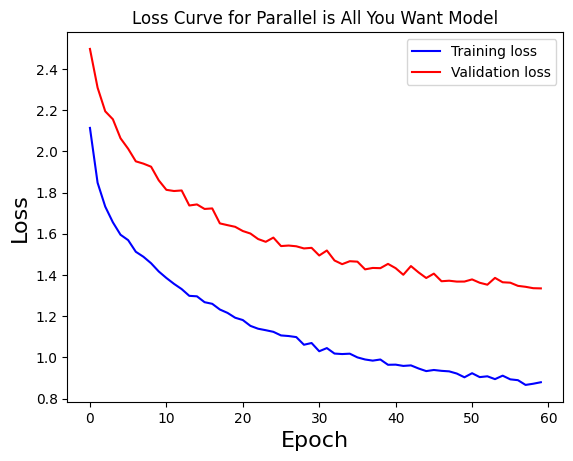

In [ ]:
plt.title('Loss Curve for Parallel is All You Want Model')
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.plot(train_losses[:],'b')
plt.plot(valid_losses[:],'r')
plt.legend(['Training loss','Validation loss'])
plt.show()

In [ ]:
        # open file in write mode and write data
filename = '/content/gdrive/MyDrive/att_w2v_kfold/losses.npy'

with open(filename, 'rb') as f:
    train_losses = np.load(f)
    train_autoencoder_losses1 =  np.load(f)
    train_autoencoder_losses2 = np.load(f)
    train_classifier_losses = np.load(f)
    valid_losses = np.load(f)
    valid_autoencoder_losses1 = np.load(f)
    valid_autoencoder_losses2 = np.load(f)
    valid_classifier_losses = np.load(f)

In [ ]:
# pick load folder
load_folder = '/content/gdrive/MyDrive/att_w2v_kfold/'

# pick the epoch to load
epoch = '60'
model_name = f'att_w2v_SpatialAttention_and_channel_attention_dropout.pkl'

# make full load path
load_path = os.path.join(load_folder, model_name)

## instantiate empty model and populate with params from binary
device = 'cuda' if  torch.cuda.is_available() else 'cpu'
model = MultiTaskModel(len(emotions_dict)).to(device)
load_checkpoint(optimizer, model, load_path)

print(f'Loaded model from {load_path}')

In [ ]:
# reinitialize validation function with model from chosen checkpoint


validate = make_validate_fnc(model,autoencoder_criterion, classifier_criterion)

test_audio_input = processor(X_test,
                              sampling_rate=16000,
                              return_tensors="pt")
with torch.no_grad():
  test_audio_input_feature = w2v(**test_audio_input).last_hidden_state

# Convert 4D test feature set array to tensor and move to GPU
X_test_tensor = torch.tensor(test_audio_input_feature,device=device).float()
features_test = torch.tensor(features_test,device=device).float()

# Convert 4D test label set array to tensor and move to GPU
y_test_tensor = torch.tensor(y_test,dtype=torch.long,device=device)

# Get the model's performance metrics using the validation function we defined
test_loss, test_acc, test_autoencoder_loss1, test_autoencoder_loss2, test_classifier_loss, predicted_emotions = validate(features_test,
                                                                                                                         X_test_tensor,
                                                                                                                         y_test_tensor)
print(f'Test accuracy is {test_acc:.2f}%')

Test accuracy is 77.39%


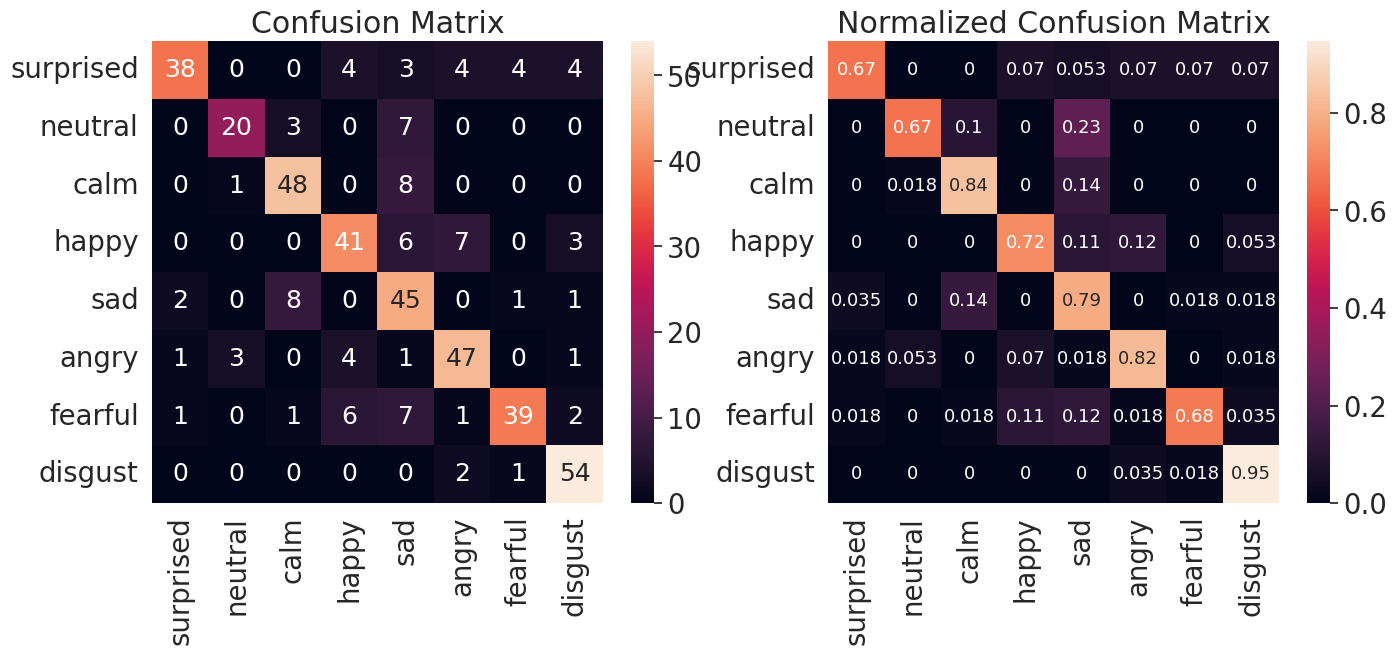

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

# because model tested on GPU, move prediction tensor to CPU then convert to array
predicted_emotions = predicted_emotions.cpu().numpy()
# use labels from test set
emotions_groundtruth = y_test

# build confusion matrix and normalized confusion matrix
conf_matrix = confusion_matrix(emotions_groundtruth, predicted_emotions)
conf_matrix_norm = confusion_matrix(emotions_groundtruth, predicted_emotions,normalize='true')

# set labels for matrix axes from emotions
emotion_names = [emotion for emotion in emotions_dict.values()]

# make a confusion matrix with labels using a DataFrame
confmatrix_df = pd.DataFrame(conf_matrix, index=emotion_names, columns=emotion_names)
confmatrix_df_norm = pd.DataFrame(conf_matrix_norm, index=emotion_names, columns=emotion_names)

# plot confusion matrices
plt.figure(figsize=(16,6))
sn.set(font_scale=1.8) # emotion label and title size
plt.subplot(1,2,1)
plt.title('Confusion Matrix')
sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 18}) #annot_kws is value font
plt.subplot(1,2,2)
plt.title('Normalized Confusion Matrix')
sn.heatmap(confmatrix_df_norm, annot=True, annot_kws={"size": 13}) #annot_kws is value font

plt.show()